In [1]:
#This along with Bag_to_DGE_processing, and the csv maker are the three main files for the project.
#Once the csv is made and entered in, uncomment/comment the section of datasets in the cell below this one to switch between LACO and 70/20/10 data splits
#Model paramters and training takes place in cells 12 and 13

csv_name = 'train_data_all.csv'

import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import torch
from torch import nn
from sklearn.utils import class_weight
import pandas as pd
import numpy as np
from datasets import load_dataset

c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import BeitFeatureExtractor

feature_extractor = BeitFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
#Leave a cow out split
# train_ds = load_dataset("DGE_training_mixed", data_dir="*/", split="train")
# val_ds = load_dataset("DGE_val_mixed", data_dir="*/", split="train")
# test_ds = load_dataset("DGE_test_mixed", data_dir="*/", split="train")

#For training with a 70/30 split, use the below code, requires manually sorting the dataset into train/test/val splits:
train_ds = load_dataset("DGE_all_70", data_dir="*/", split="train")
val_ds = load_dataset("DGE_all_20", data_dir="*/", split="train")
test_ds = load_dataset("DGE_all_10", data_dir="*/", split="train")

Resolving data files: 100%|██████████| 4038/4038 [00:00<00:00, 11090.93it/s]
Using custom data configuration DGE_all_70-18e391124edea51e
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_all_70-18e391124edea51e\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)
Resolving data files: 100%|██████████| 1152/1152 [00:00<00:00, 230339.81it/s]
Using custom data configuration DGE_all_20-b199606014dd3027
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_all_20-b199606014dd3027\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)
Resolving data files: 100%|██████████| 574/574 [00:00<00:00, 286952.38it/s]
Using custom data configuration DGE_all_10-9b1d13aa40bce860
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_all_10-9b1d13aa40bce860\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


In [3]:
print(train_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 4038
})


In [4]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
print(label2id)

{'2': 0, '3': 1, '4': 2, '5': 3, '6': 4}


In [5]:
#originally did not include the resize operation in the train transforms
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor,
                                    RandomRotation)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [   
            #Resize(feature_extractor.size),
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [6]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

[2.11413613 2.1536     0.52373541 0.60859081 1.96019417]


Text(0.5, 1.0, 'Sampler Weights')

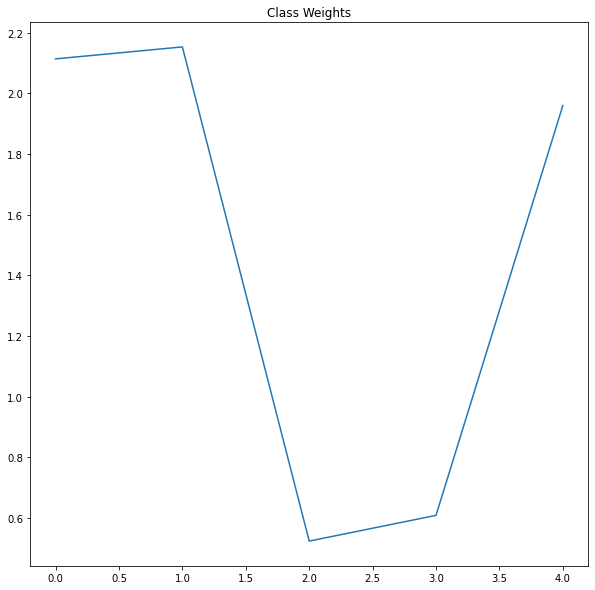

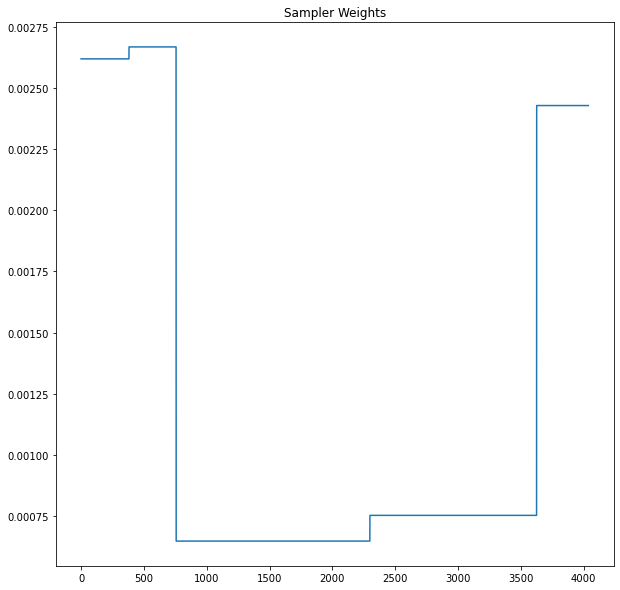

In [7]:
from sklearn.utils import class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#--------------------put the csv name here vvvv -----------------
train_df = pd.read_csv(csv_name,dtype=str)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y =train_df['class'])
print(class_weights)

# dataset_size = len(train_ds[:]['label'])
# train_count = int(dataset_size * 0.7)
# val_count = int(dataset_size - train_count)
y_train = train_ds[:]['label']

#print(train_dataset[0])
import numpy as np 

#y_train_indices = train_dataset["train"].indices

#y_train = train_ds[:]['label']

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

plt.figure(figsize=(10,10))
plt.plot(class_weights)
plt.title('Class Weights')

plt.figure(figsize=(10,10))
plt.plot(samples_weight)
plt.title('Sampler Weights')

In [8]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 16
eval_batch_size = 8

#the index errors are caused by the dataloaders indexing values that are out of bounds!

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=train_batch_size, sampler=sampler)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size)#, sampler=sampler)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=train_batch_size)

In [9]:
#print(val_ds['label'][:])
print(len(val_dataloader.dataset))
print(len(pd.read_csv('val_data_mixed.csv',dtype=str)['class']))

1152
1462


In [10]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([16, 3, 224, 224])
labels torch.Size([16])


In [11]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)

In [12]:
import pytorch_lightning as pl
from transformers import BeitForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224",
                                                              num_labels=5,
                                                              id2label=id2label,
                                                              label2id=label2id,
                                                              ignore_mismatched_sizes=True)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        #criterion = nn.CrossEntropyLoss()
        criterion = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor(class_weights))
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_accuracy", accuracy, on_epoch=True)

        return loss, accuracy

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=1e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader
    
    def test_dataloader(self):
        return test_dataloader
    
    def predict_dataloader(self):
        return test_dataloader

In [13]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='validation_loss',
    patience=0,
    strict=False,
    verbose=True,
    mode='min',
    check_on_train_epoch_end=True
)

#checkpoint = ModelCheckpoint(dirpath='VIT_models\\', filename='{epoch}-{validation_loss:.2f}-{validation_accuracy:.2f}', monitor='validation_loss', save_top_k=2)

model = ViTLightningModule()
trainer = Trainer(accelerator='gpu', devices=1, callbacks=[early_stop_callback],#, checkpoint],
    enable_checkpointing=False,
    logger=False,
    check_val_every_n_epoch=1, 
    max_epochs=2,
    min_epochs=0,
    )

trainer.fit(model)

c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using:

In [14]:
import pytorch_lightning
pytorch_lightning.utilities.model_summary.ModelSummary(model, max_depth=-1)

    | Name                                                                 | Type                       | Params
----------------------------------------------------------------------------------------------------------------------
0   | vit                                                                  | BeitForImageClassification | 85.8 M
1   | vit.beit                                                             | BeitModel                  | 85.8 M
2   | vit.beit.embeddings                                                  | BeitEmbeddings             | 591 K 
3   | vit.beit.embeddings.patch_embeddings                                 | BeitPatchEmbeddings        | 590 K 
4   | vit.beit.embeddings.patch_embeddings.projection                      | Conv2d                     | 590 K 
5   | vit.beit.embeddings.dropout                                          | Dropout                    | 0     
6   | vit.beit.encoder                                                     | BeitEncoder  

In [15]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sn
# import sklearn.metrics
# import gc
# from IPython.display import clear_output
# import glob
# import sklearn


# model = ViTLightningModule()
# trainer = Trainer(accelerator='gpu', devices=1, callbacks=[early_stop_callback],#, checkpoint],
#     check_val_every_n_epoch=1, 
#     max_epochs=5,
#     min_epochs=0,
#     )
# trainer.fit(model)

# y_pred = []
# y_true = []
# model.to('cuda')
# model.eval()
# for batch in test_dataloader:
#     labels = batch['labels'].to('cuda')
#     outputs = model(batch['pixel_values'].type('torch.cuda.FloatTensor'))
#     predictions=np.argmax(outputs.cpu().detach().numpy(), axis=-1)
#     y_pred.append(predictions)
#     y_true.append(labels.cpu().detach().numpy())
    

# y_true_total = []
# for i in range(np.shape(y_true)[0]):
#     for j in range(len(y_true[i])):
#         y_true_total.append(y_true[i][j])

# y_pred_total = []
# for i in range(np.shape(y_pred)[0]):
#     for j in range(len(y_pred[i])):
#         y_pred_total.append(y_pred[i][j])
    


# cf_matrix = confusion_matrix(y_true_total, y_pred_total)

# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = range(0, 5),
#                  columns = range(0, 5))

# clear_output(wait=True)

    
# plt.figure(figsize=(5,5))
# sn.heatmap(df_cm, annot=True)
# #sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true_total, y_pred_total, display_labels=[2, 3, 4, 5, 6], cmap='gray', colorbar=False)
# plt.title('Exact Match Confusion Matrix')
# plt.xlabel('Predicted BCS')
# plt.ylabel('True BCS')
# plt.show()
# # plt.xticks([0, 1, 2, 3, 4], [2, 3, 4, 5, 6])
# # plt.yticks([0, 1, 2, 3, 4], [2, 3, 4, 5, 6])



# #metrics
# accuracy = sklearn.metrics.accuracy_score(y_true_total, y_pred_total)
# #print('Model accuarcy is: ', accuracy)
# precision = sklearn.metrics.precision_score(y_true_total,y_pred_total, average='macro')
# #print('Model precision is: ', precision)

# f1_score = sklearn.metrics.f1_score(y_true_total,y_pred_total, average='macro')
# #print('Model f1_score is: ', f1_score)

# recall = sklearn.metrics.recall_score(y_true_total,y_pred_total, average='macro')
# #print('Model recall is: ', recall)

# MSE = sklearn.metrics.mean_squared_error(y_true_total,y_pred_total)
# #print('Model MSE is: ', MSE)

# print('Accuracy: ', round(accuracy, 2), 'Precision: ', round(precision, 2), 'Recall: ', round(recall, 2), 'F1 Score: ', round(f1_score, 2), 'MSE: ', round(MSE, 2))

#     # vit_models = glob.glob('VIT_models\\*')
#     # accuracies = []
#     # for name in vit_models:
#     #     accuracies.append(float(name[len('VIT_models\BEiT_'):-len('_0.20.ckpt')]))
    
#     # if (accuracy > np.asarray(accuracies)).all():
#     #     trainer.save_checkpoint(f"VIT_models\BEiT_{round(accuracy, 2)}_{round(MSE, 2)}.ckpt")


#     # MSEs = []
#     # for name in vit_models:
#     #     MSEs.append(float(name[len('VIT_models\BEiT_0.44_'):-len('.ckpt')]))
    
#     # if (MSE < np.asarray(MSEs)).all():
#     #     trainer.save_checkpoint(f"VIT_models\BEiT_{round(accuracy, 2)}_{round(MSE, 3)}.ckpt")

    


#     # model.to('cpu')
#     # model = None
#     # trainer = None
#     # del trainer
#     # del model
#     # torch.cuda.empty_cache()

#     # gc.collect()

#     # for obj in gc.get_objects():
#     #     try:
#     #         if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#     #             #print(type(obj), obj.size())
#     #             del obj
#     #     except:
#     #         pass

    

In [16]:
#trainer.test(model=model, dataloaders=test_dataloader, verbose=True)


#trainer.test(model=model, dataloaders=val_dataloader, verbose=True)

In [17]:
#return

In [18]:
y_pred = []
y_true = []
model.to('cuda')
model.eval()
for batch in test_dataloader:
    labels = batch['labels'].to('cuda')
    outputs = model(batch['pixel_values'].type('torch.cuda.FloatTensor'))
    predictions=np.argmax(outputs.cpu().detach().numpy(), axis=-1)
    y_pred.append(predictions)
    y_true.append(labels.cpu().detach().numpy())
    #metric.add_batch(predictions=predictions, references=labels)

In [19]:
y_true_total = []
for i in range(np.shape(y_true)[0]):
    for j in range(len(y_true[i])):
        y_true_total.append(y_true[i][j])

y_pred_total = []
for i in range(np.shape(y_pred)[0]):
    for j in range(len(y_pred[i])):
        y_pred_total.append(y_pred[i][j])

print(len(y_pred_total))
print(len(y_true_total))

print(np.shape(y_pred)[0])
print(np.shape(y_true)[0])

574
574
36
36


c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


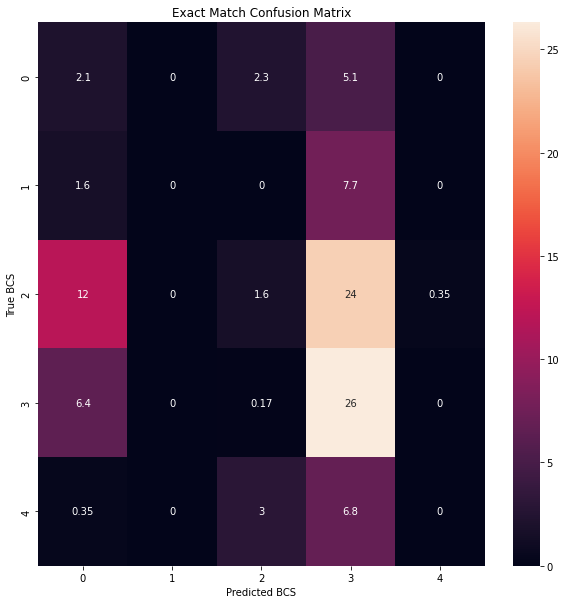

Model accuarcy is:  0.29965156794425085
Model precision is:  0.1385426164233366
Model f1_score is:  0.1421026890699022
Model recall is:  0.2124146224146224
Model MSE is:  2.4303135888501743
Confusion Matrix
[[ 12   0  13  29   0]
 [  9   0   0  44   0]
 [ 69   0   9 140   2]
 [ 37   0   1 151   0]
 [  2   0  17  39   0]]


c:\Users\zacha\anaconda3\envs\ML_env_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sklearn.metrics


cf_matrix = confusion_matrix(y_true_total, y_pred_total)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = range(0, 5),
                     columns = range(0, 5))


plt.figure(figsize=(10,10))
sn.heatmap(df_cm, annot=True)
#sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true_total, y_pred_total, display_labels=[2, 3, 4, 5, 6], cmap='gray', colorbar=False)
plt.title('Exact Match Confusion Matrix')
plt.xlabel('Predicted BCS')
plt.ylabel('True BCS')
plt.show()
# plt.xticks([0, 1, 2, 3, 4], [2, 3, 4, 5, 6])
# plt.yticks([0, 1, 2, 3, 4], [2, 3, 4, 5, 6])



import sklearn
#metrics
accuarcy = sklearn.metrics.accuracy_score(y_true_total, y_pred_total)
print('Model accuarcy is: ', accuarcy)
precision = sklearn.metrics.precision_score(y_true_total,y_pred_total, average='macro')
print('Model precision is: ', precision)

f1_score = sklearn.metrics.f1_score(y_true_total,y_pred_total, average='macro')
print('Model f1_score is: ', f1_score)

recall = sklearn.metrics.recall_score(y_true_total,y_pred_total, average='macro')
print('Model recall is: ', recall)

MSE = sklearn.metrics.mean_squared_error(y_true_total,y_pred_total)
print('Model MSE is: ', MSE)

print("Confusion Matrix")
print(cf_matrix)

The accuracy of the network model2 is:  0.6289198606271778
Model unweighted precision is:  0.7118354604775098
Model weighted precision is:  0.7393366260059736

Model unweighted recall is:  0.5091905735171838
Model weighted recall is:  0.6289198606271778

Model unweighted f1_score is:  0.539459817566944
Model weighted f1_score is:  0.647431581831429

Confusion Matrix
[[ 12   0  13  29   0]
 [  0   9   0  44   0]
 [ 69   0 149   0   2]
 [ 37   0   0 152   0]
 [  2   0  17   0  39]]


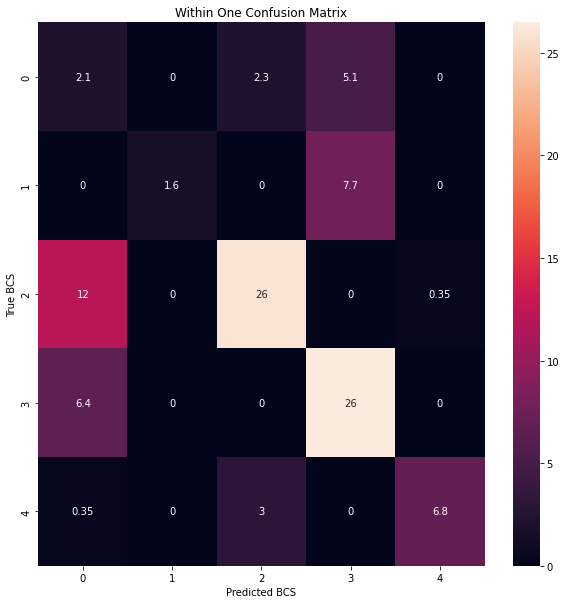

In [21]:
y_within_1 = []
for i in range(0, len(y_true_total)):
    if ((y_pred_total[i] == y_true_total[i]+1) or (y_pred_total[i] == y_true_total[i]-1) or (y_pred_total[i] == y_true_total[i])):
        y_within_1.append(y_true_total[i])
    else:
        y_within_1.append(y_pred_total[i])

# print(y_within_1)
# print(type(y_within_1[20]))
# print(type(y_true_total[0]))


cf_matrix = confusion_matrix(y_true_total, y_within_1)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = range(0, 5),
                     columns = range(0, 5))


plt.figure(figsize=(10,10))
sn.heatmap(df_cm, annot=True)
plt.title('Within One Confusion Matrix')
plt.xlabel('Predicted BCS')
plt.ylabel('True BCS')


con_matrix = sklearn.metrics.confusion_matrix(y_true_total,y_within_1)
acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()


print('The accuracy of the network model2 is: ', acc)

min = np.min(con_matrix)
max = np.max(con_matrix)
temp_mat = con_matrix - min
temp_mat = con_matrix/max

#Metrics
precision = sklearn.metrics.precision_score(y_true_total,y_within_1, average='macro')
print('Model unweighted precision is: ', precision)
precision = sklearn.metrics.precision_score(y_true_total,y_within_1, average='weighted')
print('Model weighted precision is: ', precision)
print()

#print('Avg :', sklearn.metrics.accuracy_score(y_test, y_test_hat, normalize=False))

recall = sklearn.metrics.recall_score(y_true_total,y_within_1, average='macro')
print('Model unweighted recall is: ', recall)
recall = sklearn.metrics.recall_score(y_true_total,y_within_1, average='weighted')
print('Model weighted recall is: ', recall)
print()

f1_score = sklearn.metrics.f1_score(y_true_total,y_within_1, average='macro')
print('Model unweighted f1_score is: ', f1_score)
f1_score = sklearn.metrics.f1_score(y_true_total,y_within_1, average='weighted')
print('Model weighted f1_score is: ', f1_score)
print()


print("Confusion Matrix")
print(con_matrix)

In [22]:
#torch.save(model, 'VIT_models\BEiT_42.pt')
# torch.save(
#     model.state_dict(),
#     'VIT_models\BEiT_42.pt'
# )

In [23]:
#trainer.save_checkpoint("VIT_models\BEiT_64_keep.ckpt")

In [24]:
# new_model = ViTLightningModule.load_from_checkpoint(checkpoint_path="VIT_models\BEiT_64_keep.ckpt")
# trainer.test(model=new_model, dataloaders=test_dataloader, verbose=True)